Analysis of Bitcoin Network Dataset

Defining function to connect with the database

In [1]:
# Importing the necessary libraries to establish connection and import data
import os
import psycopg2

# Function for connecting to the database and making it ready to feed requests
def newCursor():
    try:
        connection = psycopg2.connect(user = os.environ["DB_USER"],
                                      host = os.environ["DB_HOST"],
                                      password = os.environ["DB_PASSWORD"],
                                      port = "5432",
                                      database = os.environ["DB_DATABASE"])

        cursor = connection.cursor()
        return cursor

    except (Exception, psycopg2.Error) as error:
        print("Error while connecting to PostgreSQL", error)
        return error

Here we import data as a Pandas Dataframe from the database

In [2]:
import pandas as pd

# Requesting import
c = newCursor()
q = """
  SELECT *
  FROM api."bitcoin_network_dataset"
"""
c.execute(q)
cols = [desc[0] for desc in c.description]

# Here is our pandas dataframe with Bitcoin Network Dataset
df = pd.DataFrame(c.fetchall(), columns=cols)

# Here is a brief description of the data collected
print('\t___________Description___________\n')
print(df.describe())

print('\n---------------------------------------------\n')

# Here is the data size
print('\t___________Shape______________\n')
print(df.shape)

	___________Description___________

                       Date btc_market_price btc_total_bitcoins  \
count                  1590             1590               1590   
unique                 1590             1260               1588   
top     2009-01-03 00:00:00              0.0               50.0   
freq                      1              296                  3   

       btc_market_cap btc_trade_volume btc_blocks_size btc_avg_block_size  \
count            1590             1590            1590               1590   
unique           1295              827            1183               1578   
top               0.0              0.0             0.0           0.000215   
freq              296              764             279                  3   

       btc_n_orphaned_blocks btc_n_transactions_per_block  \
count                   1590                         1590   
unique                     6                          817   
top                      0.0                          1.0  

Here we have a plotter for the column desired to get a overview of the data given

Column Name:  btc_market_price


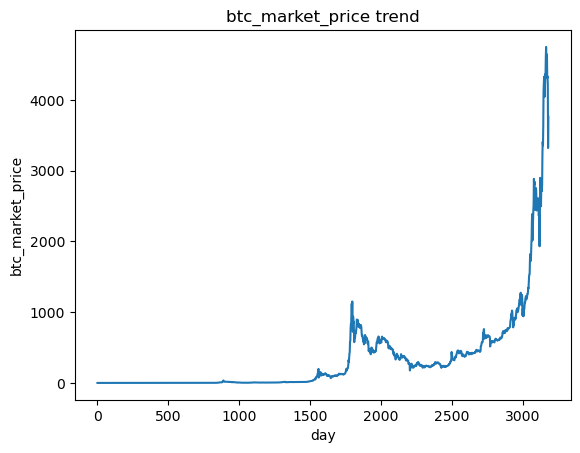

In [3]:
# We use matplotlib and numpy libraries for this task
import numpy as np
import matplotlib.pyplot as plt

def daywise_plot(column_name):
    y = df[column_name].to_numpy()
    x = np.arange(0, 2*(y.size), 2)
    
    plt.xlabel('day')
    plt.title(column_name + ' trend')
    plt.ylabel(column_name)
    plt.plot(x, y)
    
    plt.show()

# Plots the requested column name
daywise_plot(input('Column Name: ').strip())

Now comes the modelling where we use a 5 degree polynomial as our Model Function.
For a good model the absolute errors it give compared to the given data should be minimum.

Here we use curve_fit function from scipy.optimize module to perform this task using their already written smart code.

Column Name:  btc_market_price
Days to predict 365


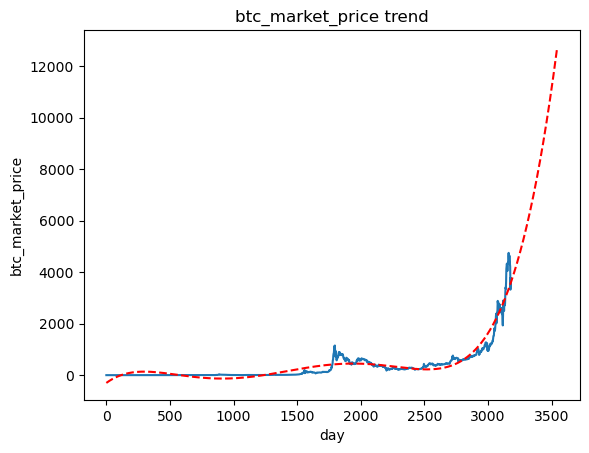

0        -301.717320
2        -294.549451
4        -287.458526
6        -280.444090
8        -273.505687
            ...     
3536    12442.200324
3538    12517.385324
3540    12592.916481
3542    12668.794904
3544    12745.021705
Name: btc_market_price modelled, Length: 1773, dtype: float64

In [4]:
from scipy.optimize import curve_fit as cf

# We observed the entries to be gapped by 2 days so used first date (2009-01-03 00:00:00) as Day-0
given_days = np.arange(0, 2*df.shape[0], 2)  # The days for which the data was given

def model_func(x, a, b, c, d, e, f):  # Independent variable as first argument followed by the parameters
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f

def daywise_model(model_func, column_name, days_ahead, show = True):    # days_ahead signify the number of days in future after the last entry for which data is to be predicted 
    paras, _ = cf(model_func, given_days, df[column_name].to_numpy())   # paras will the list of the parameters in the same order as the function takes

    all_days = np.arange(0, 2*df.shape[0] + days_ahead, 2)
    df_predict = pd.Series(model_func(all_days, *paras), index = all_days, name = column_name + ' modelled')
    
    # Plotting the result
    if show:
        plt.plot(given_days, df[column_name].to_numpy())
        plt.plot(all_days, model_func(all_days, *paras), 'r--')
        plt.xlabel('day')
        plt.title(column_name + ' trend')
        plt.ylabel(column_name)
        plt.show()
    
    return df_predict

# Models the requested column name with the days to be predicted
daywise_model(model_func, input('Column Name: ').strip(), int(input('Days to predict')))

Now we will generate the complete model dataframe using the 5 degree dataframe for all columns to reduce complicacy

Number of days to be predicted:  30


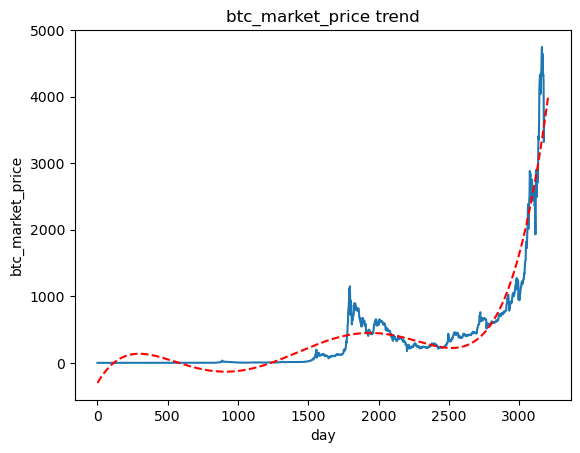

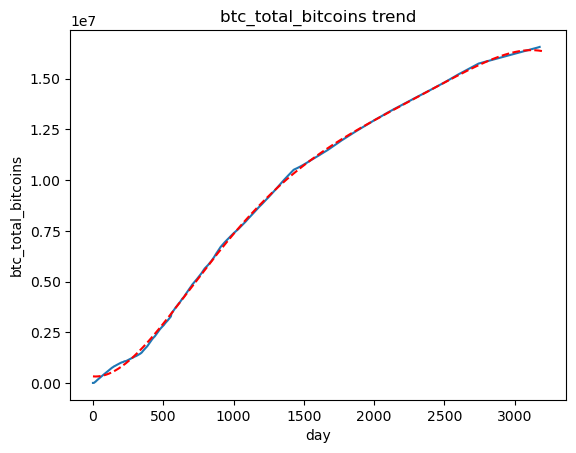

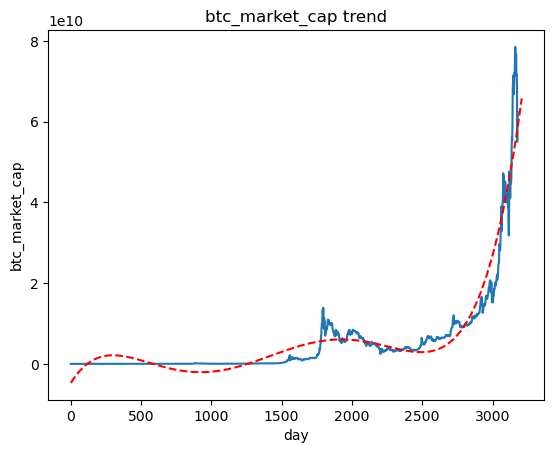

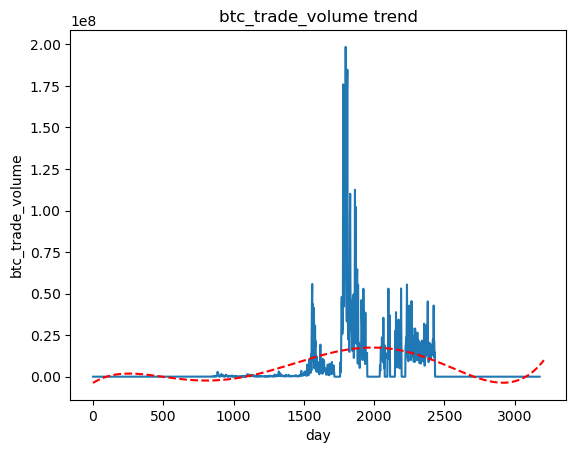

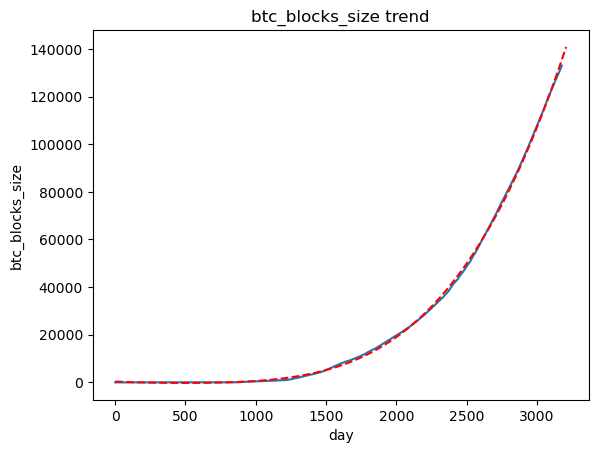

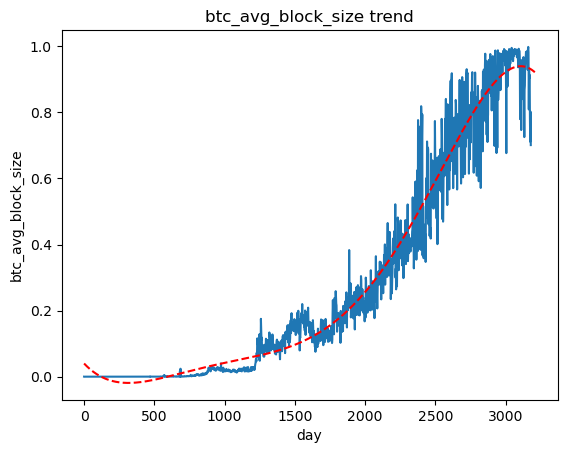

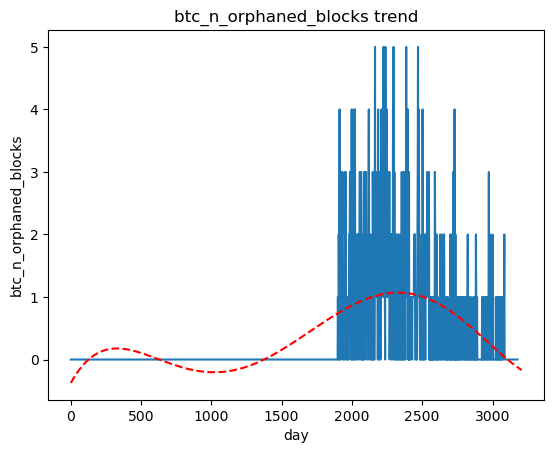

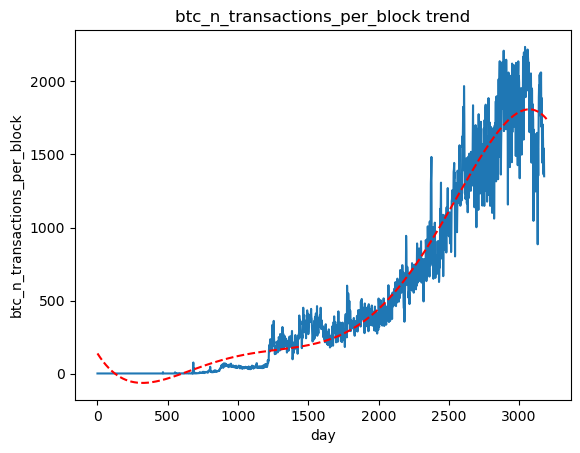

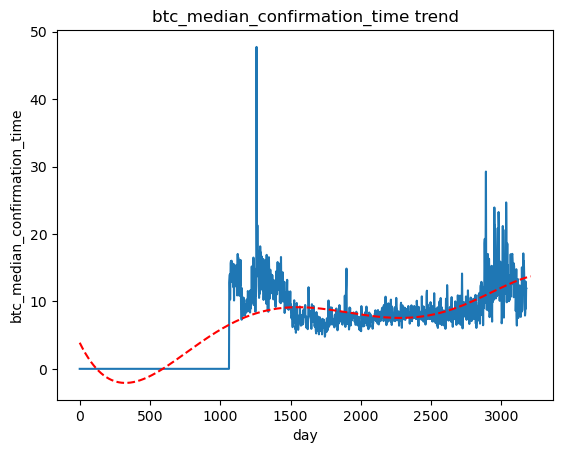

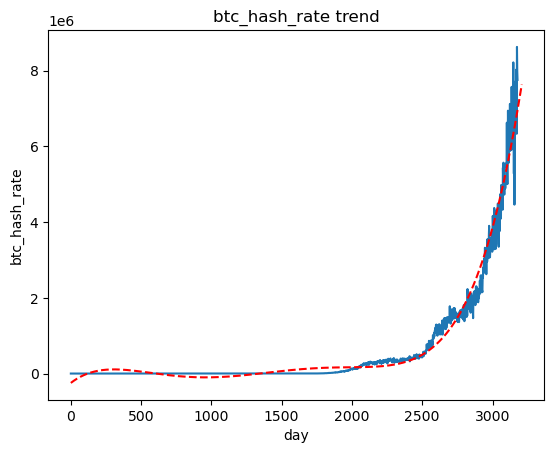

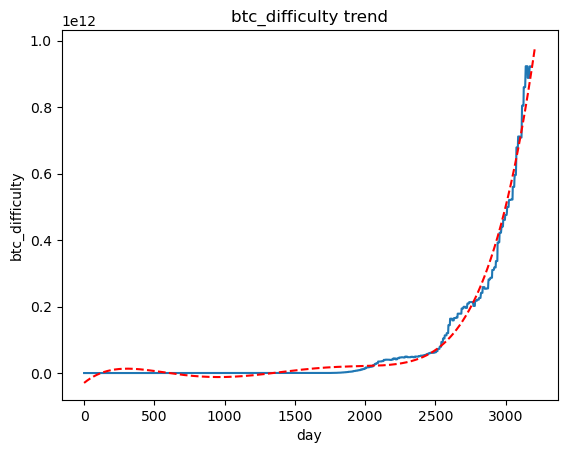

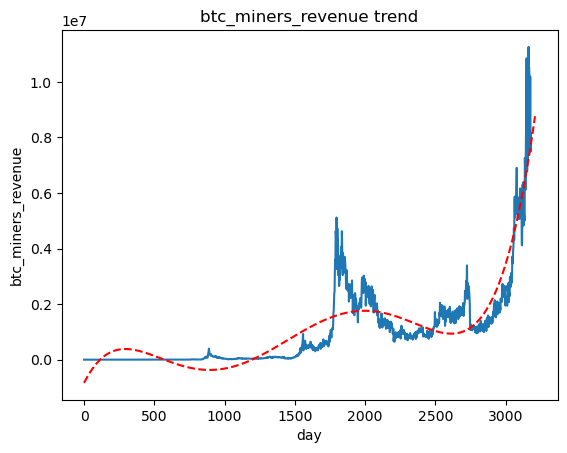

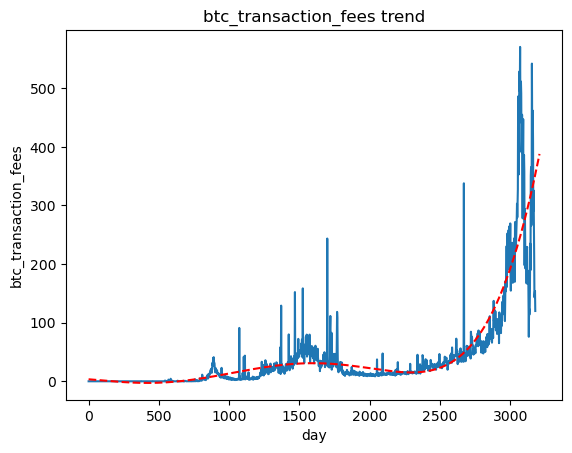

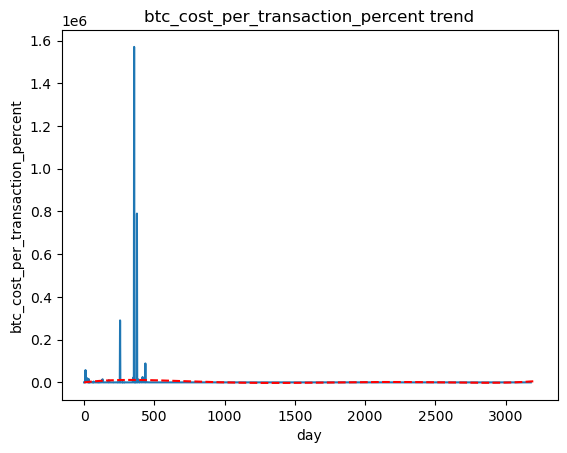

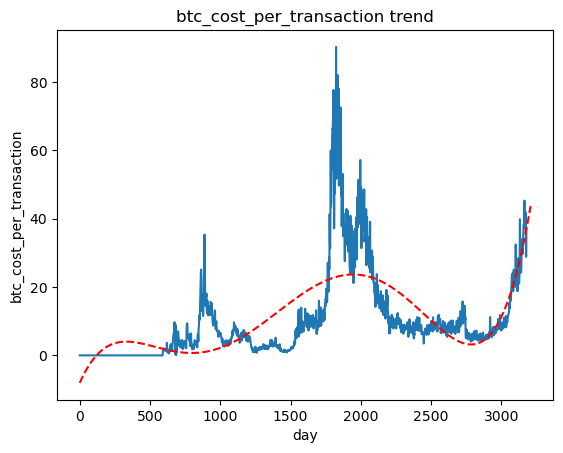

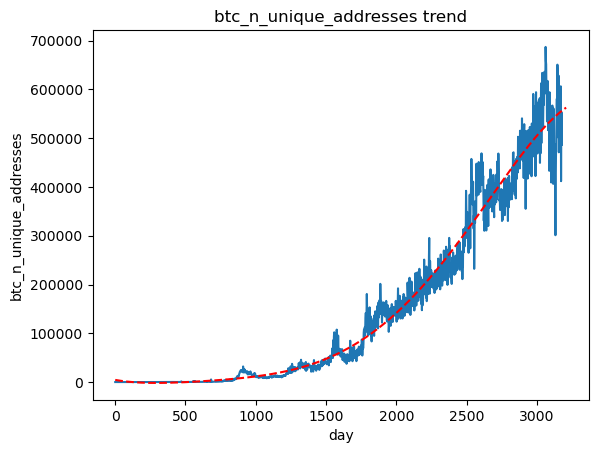

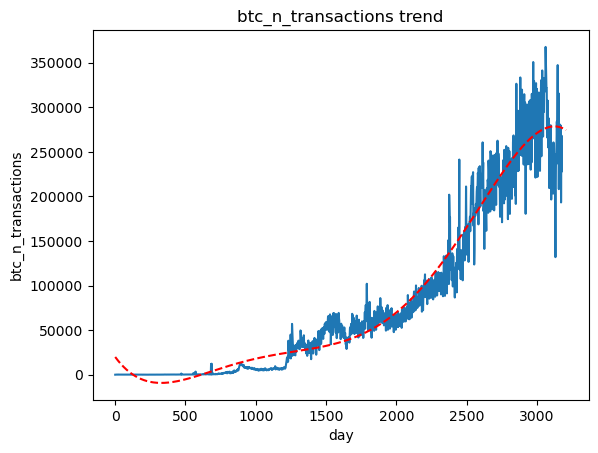

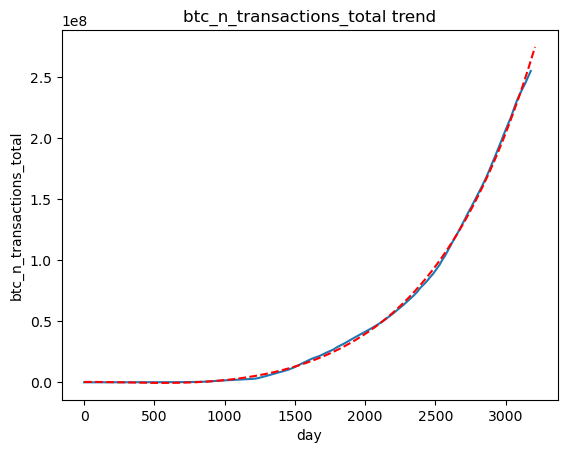

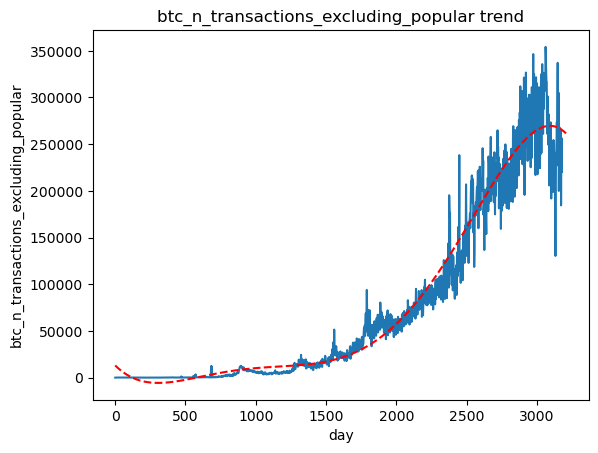

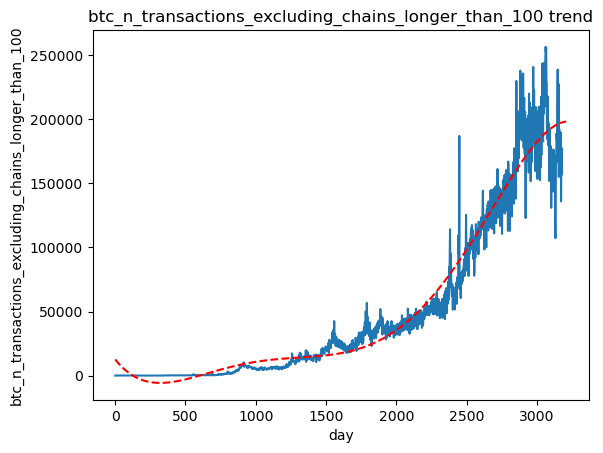

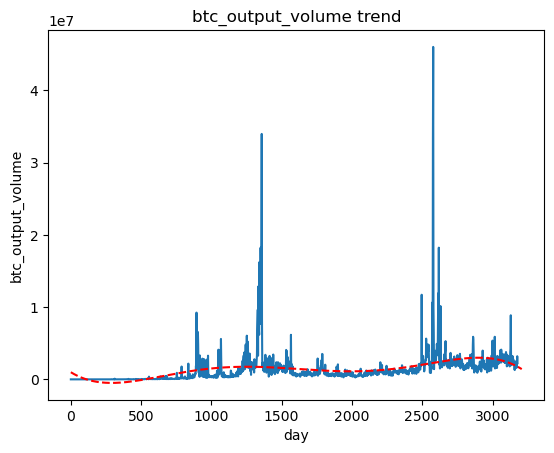

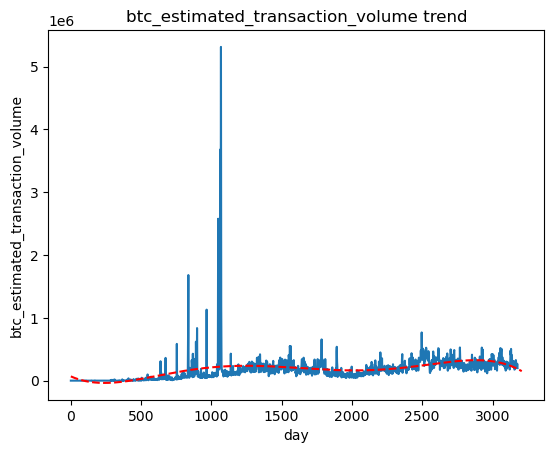

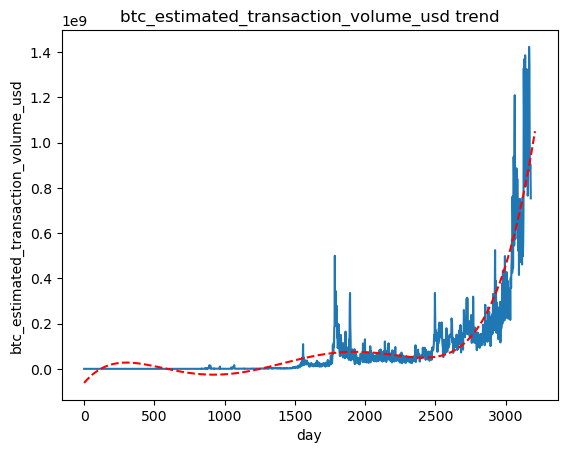

	_____________Description____________

       btc_market_price modelled  btc_total_bitcoins modelled  \
count                1605.000000                 1.605000e+03   
mean                  380.700406                 9.944163e+06   
std                   700.318356                 5.189641e+06   
min                  -301.717320                 3.173981e+05   
25%                     8.075197                 5.637252e+06   
50%                   230.299770                 1.126242e+07   
75%                   414.736450                 1.446346e+07   
max                  4031.254293                 1.641225e+07   

       btc_market_cap modelled  btc_trade_volume modelled  \
count             1.605000e+03               1.605000e+03   
mean              5.815443e+09               5.016059e+06   
std               1.150746e+10               7.010287e+06   
min              -4.721268e+09              -3.749135e+06   
25%               5.055506e+07              -1.028699e+06   
50%      

,btc_market_price modelled,btc_total_bitcoins modelled,btc_market_cap modelled,btc_trade_volume modelled,btc_blocks_size modelled,btc_avg_block_size modelled,btc_n_orphaned_blocks modelled,btc_n_transactions_per_block modelled,btc_median_confirmation_time modelled,btc_hash_rate modelled,...,btc_cost_per_transaction_percent modelled,btc_cost_per_transaction modelled,btc_n_unique_addresses modelled,btc_n_transactions modelled,btc_n_transactions_total modelled,btc_n_transactions_excluding_popular modelled,btc_n_transactions_excluding_chains_longer_than_100 modelled,btc_output_volume modelled,btc_estimated_transaction_volume modelled,btc_estimated_transaction_volume_usd modelled
0,-301.717320,3.228075e+05,-4.721268e+09,-3.749135e+06,353.329549,0.040045,-0.374272,138.094928,3.871868,-2.474349e+05,...,-11.445843,-8.057608,4411.293732,19876.315659,3.172229e+05,13085.460352,12649.943071,9.868244e+05,67719.685472,-6.215792e+07
2,-294.549451,3.216604e+05,-4.610206e+09,-3.644961e+06,347.780565,0.039145,-0.366192,135.057270,3.786932,-2.417402e+05,...,150.965730,-7.873638,4309.443182,19447.778659,3.191283e+05,12787.737091,12374.538264,9.630236e+05,65747.919783,-6.070369e+07
4,-287.458526,3.206513e+05,-4.500328e+09,-3.542031e+06,342.270638,0.038255,-0.358189,132.049469,3.702756,-2.361057e+05,...,311.904542,-7.691557,4208.700391,19023.356576,3.209312e+05,12493.124458,12101.830298,9.394651e+05,63799.136378,-5.926494e+07
6,-280.444090,3.197795e+05,-4.391626e+09,-3.440337e+06,336.799541,0.037374,-0.350263,129.071361,3.619334,-2.305311e+05,...,471.377580,-7.511356,4109.058402,18603.027682,3.226325e+05,12201.604321,11831.804717,9.161479e+05,61873.213417,-5.784160e+07
8,-273.505687,3.190445e+05,-4.284094e+09,-3.339870e+06,331.367045,0.036501,-0.342412,126.122785,3.536664,-2.250160e+05,...,629.391815,-7.333022,4010.510288,18186.770317,3.242330e+05,11913.158608,11564.447108,8.930706e+05,59970.029408,-5.643357e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3200,3905.793404,1.635919e+07,6.375108e+10,9.105894e+06,139433.484906,0.924036,-0.156704,1736.820772,13.681350,7.444798e+06,...,5253.577836,41.788186,561206.322497,275198.841270,2.717980e+08,262586.000262,198127.810941,1.515488e+06,161178.273027,1.019804e+09
3202,3936.873721,1.635641e+07,6.425149e+10,9.316450e+06,139789.177158,0.923320,-0.159603,1734.413390,13.692360,7.490824e+06,...,5358.225845,42.252660,561621.440035,275012.362906,2.725606e+08,262305.901852,198162.577631,1.491941e+06,158688.221116,1.027290e+09
3204,3968.143463,1.635357e+07,6.475489e+10,9.529161e+06,140145.513981,0.922588,-0.162478,1731.961968,13.703218,7.537076e+06,...,5463.885072,42.720827,562033.116097,274820.482776,2.733250e+08,262019.862725,198194.372703,1.468157e+06,156174.103079,1.034818e+09
3206,3999.603397,1.635064e+07,6.526129e+10,9.744040e+06,140502.496014,0.921838,-0.165331,1729.466287,13.713923,7.583553e+06,...,5570.561057,43.192704,562441.332524,274623.173144,2.740913e+08,261727.854009,198223.179182,1.444135e+06,153635.795201,1.042389e+09


In [9]:
# Here we use days as index
def dataframe_predicted(days_ahead, model_func, show):
    cols = [x for x in df if x != 'Date']
    
    df_guess = daywise_model(model_func, cols[0], days_ahead, show)
    df_guess = pd.DataFrame(df_guess)
    
    n = len(cols)
    for i in range(1, n):
        df_guess = df_guess.join(daywise_model(model_func, cols[i], days_ahead, show))
        
    return df_guess

prediction = dataframe_predicted(int(input('Number of days to be predicted: ')), model_func, True)

# Here is a brief description of the model data
print('\t_____________Description____________\n')
print(prediction.describe())

print('\n--------------------------------------------------------------------------\n')

# Here is how the dataframe looks
print('\t______________DataFrame_____________\n')
prediction

In [10]:
dataframe_predicted(365, model_func, False).to_csv('/home/jovyan/synthetic_data_submission.csv')